In [1]:
!pip install kaggle dagshub mlflow -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.8/733.8 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 225MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [5]:
!unzip train.csv.zip
!unzip stores.csv.zip
!unzip features.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.
Archive:  features.csv.zip
  inflating: features.csv            
Archive:  test.csv.zip
  inflating: test.csv                


In [150]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import dagshub
import mlflow
import mlflow.pytorch
import joblib
import warnings

In [151]:
class Config:
    lookback = 20
    horizon = 1
    batch_size = 64
    dropout = 0
    epochs = 10
    lr = 1e-3
    random_state = 42
    test_size = 0.2
    model_name = "DLinear"
    experiment_name = "DLinear_Training"
    lag_features = [1, 2, 3, 4, 8, 12, 24, 52]
    use_rolling_stats = True
    rolling_windows = [4, 8, 12]

config = Config()

In [152]:
dagshub.init(repo_owner='Cimbir', repo_name='Store-Sales-Forecasting', mlflow=True)

Initialized MLflow to track repo "Cimbir/Store-Sales-Forecasting"

Repository Cimbir/Store-Sales-Forecasting initialized!

In [153]:
warnings.filterwarnings('ignore')

In [154]:
torch.manual_seed(config.random_state)
np.random.seed(config.random_state)

In [155]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [156]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [157]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [158]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# Evaluation function

In [159]:
def weighted_mae_loss(y_pred, y_true, is_holiday):
    weights = torch.where(is_holiday, 5.0, 1.0).to(y_pred.device)
    return torch.sum(weights * torch.abs(y_true - y_pred)) / torch.sum(weights)

In [160]:
features['Date'] = pd.to_datetime(features['Date'])
train['Date'] = pd.to_datetime(train['Date'])

df = pd.merge(train, features, on=['Store', 'Date'], how='left')
df = pd.merge(df, stores, on='Store', how='left')
df = df.rename(columns={'IsHoliday_x': 'IsHoliday'}).drop(columns=['IsHoliday_y'])
df.fillna(0, inplace=True)
df.sort_values(['Store', 'Dept', 'Date'], inplace=True)

In [161]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, meta, df):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        meta_df = pd.DataFrame(meta, columns=["Store", "Dept", "Date"])
        meta_df['Date'] = pd.to_datetime(meta_df['Date'])
        self.meta = meta_df.to_dict("records")
        flags = df[['Store', 'Dept', 'Date', 'IsHoliday']].drop_duplicates()
        merged = meta_df.merge(flags, on=['Store', 'Dept', 'Date'], how='left')
        self.is_holiday = torch.tensor(merged['IsHoliday'].astype(bool).values, dtype=torch.bool)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.is_holiday[idx]

In [162]:
class DLinearWithLags(nn.Module):
    def __init__(self, lookback, horizon, n_features):
        super().__init__()
        self.lookback = lookback
        self.horizon = horizon
        self.n_features = n_features
        self.linear = nn.Linear(lookback * n_features, horizon)

        self.use_mlp = True
        if self.use_mlp:
            hidden_size = min(256, lookback * n_features // 2)
            self.mlp = nn.Sequential(
                nn.Linear(lookback * n_features, hidden_size),
                nn.LeakyReLU(),
                nn.Dropout(config.dropout),
                nn.Linear(hidden_size, horizon)
            )

    def forward(self, x):
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        if self.use_mlp:
            return self.mlp(x_flat)
        else:
            return self.linear(x_flat)

In [163]:
class DLinearPipeline:
    def __init__(self, config):
        self.config = config
        self.model = None

    def create_lag_features(self, ts):
        features_list = []
        features_list.append(ts.values.reshape(-1, 1))

        dates = ts.index
        features_list.append(dates.year.values.reshape(-1, 1))
        features_list.append(dates.month.values.reshape(-1, 1))
        features_list.append(dates.day.values.reshape(-1, 1))


        for lag in self.config.lag_features:
            lagged = ts.shift(lag).values.reshape(-1, 1)
            features_list.append(lagged)
        if self.config.use_rolling_stats:
            for window in self.config.rolling_windows:
                roll_mean = ts.rolling(window=window, min_periods=1).mean().values.reshape(-1, 1)
                features_list.append(roll_mean)
                roll_std = ts.rolling(window=window, min_periods=1).std().fillna(0).values.reshape(-1, 1)
                features_list.append(roll_std)
        feature_matrix = np.concatenate(features_list, axis=1)
        return feature_matrix


    def generate_all_windows(self, df):
        X, y, meta = [], [], []
        for (store, dept), group in df.groupby(['Store', 'Dept']):
            ts = group.set_index('Date')['Weekly_Sales'].resample('W-FRI').sum().sort_index()
            dates = ts.index
            if len(ts) < max(self.config.lag_features) + self.config.lookback + self.config.horizon:
                continue
            feature_matrix = self.create_lag_features(ts)
            max_lag = max(self.config.lag_features) if self.config.lag_features else 0
            start_idx = max_lag + self.config.lookback
            for i in range(start_idx, len(ts) - self.config.horizon + 1):
                X_window = feature_matrix[i - self.config.lookback:i]
                y_window = ts.iloc[i:i + self.config.horizon].values
                X.append(X_window)
                y.append(y_window)
                meta.append((store, dept, dates[i + self.config.horizon - 1]))
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), np.array(meta)

    def time_based_split(self, X, y, meta):
        dates = [m[2] for m in meta]
        sorted_indices = np.argsort(dates)
        split_idx = int(len(sorted_indices) * (1 - self.config.test_size))
        train_idx = sorted_indices[:split_idx]
        val_idx = sorted_indices[split_idx:]
        return X[train_idx], X[val_idx], y[train_idx], y[val_idx], meta[train_idx], meta[val_idx]

    def fit(self, df):
        X, y, meta = self.generate_all_windows(df)
        X_train, X_val, y_train, y_val, meta_train, meta_val = self.time_based_split(X, y, meta)

        train_ds = TimeSeriesDataset(X_train, y_train, meta_train, df)
        val_ds = TimeSeriesDataset(X_val, y_val, meta_val, df)
        train_loader = DataLoader(train_ds, batch_size=self.config.batch_size, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=self.config.batch_size)

        n_features = X.shape[2]
        self.model = DLinearWithLags(self.config.lookback, self.config.horizon, n_features)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)

        print("Starting training...")
        for epoch in range(self.config.epochs):
            self.model.train()
            train_loss = 0
            for batch_x, batch_y, batch_holiday in train_loader:
                optimizer.zero_grad()
                preds = self.model(batch_x)
                loss = weighted_mae_loss(preds, batch_y, batch_holiday)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_x, batch_y, batch_holiday in val_loader:
                    preds = self.model(batch_x)
                    loss = weighted_mae_loss(preds, batch_y, batch_holiday)
                    val_loss += loss.item()

            print(f"Epoch {epoch+1}/{self.config.epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Val Loss: {val_loss/len(val_loader):.4f}")

        self.meta_train = meta_train
        self.meta_val = meta_val
        self.train_loader = train_loader
        self.val_loader = val_loader

        return self.model

    def predict(self, df):
        X, meta = [], []
        for (store, dept), group in df.groupby(['Store', 'Dept']):
            ts = group.set_index('Date')['Weekly_Sales'].resample('W-FRI').sum().sort_index()
            dates = ts.index
            if len(ts) < max(self.config.lag_features) + self.config.lookback + self.config.horizon:
                continue
            feature_matrix = self.create_lag_features(ts)
            max_lag = max(self.config.lag_features) if self.config.lag_features else 0
            start_idx = max_lag + self.config.lookback
            for i in range(start_idx, len(ts) - self.config.horizon + 1):
                X_window = feature_matrix[i - self.config.lookback:i]
                X.append(X_window)
                meta.append((store, dept, dates[i + self.config.horizon - 1]))

        if len(X) == 0:
            return [], []

        X = np.array(X, dtype=np.float32)
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy()

        return preds, meta

In [164]:
def evaluate_model(model, data_loader, dataset_name="Dataset"):
    model.eval()
    all_predictions = []
    all_targets = []
    all_holidays = []
    all_stores = []

    with torch.no_grad():
        for i, (batch_x, batch_y, batch_holiday) in enumerate(data_loader):
            predictions = model(batch_x)

            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_targets.extend(batch_y.cpu().numpy().flatten())
            all_holidays.extend(batch_holiday.cpu().numpy())

            batch_size = len(batch_x)
            start_idx = i * data_loader.batch_size
            end_idx = start_idx + batch_size
            stores = [data_loader.dataset.meta[j]['Store'] for j in range(start_idx, min(end_idx, len(data_loader.dataset.meta)))]
            all_stores.extend(stores)

    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)
    errors = y_pred - y_true

    weights = np.where(all_holidays, 5.0, 1.0)
    wmae = np.sum(weights * np.abs(errors)) / np.sum(weights)

    mean_error = np.mean(errors)
    bias_direction = "over-predicting" if mean_error > 0 else "under-predicting"

    error_std = np.std(errors)

    store_df = pd.DataFrame({
        'store': all_stores,
        'actual': y_true,
        'predicted': y_pred,
        'abs_error': np.abs(errors)
    })

    store_stats = store_df.groupby('store')['abs_error'].agg(['mean', 'count']).reset_index()
    store_stats = store_stats[store_stats['count'] >= 5]

    print(f"\n{'='*50}")
    print(f"{dataset_name.upper()} EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"WMAE (Weighted MAE): {wmae:.2f}")
    print(f"Bias: {mean_error:.2f} (Model is {bias_direction} by ${abs(mean_error):.2f} on average)")
    print(f"Error Std Dev: {error_std:.2f} (Prediction consistency)")
    print(f"Store Performance:")
    print(f"Best Store MAE: {store_stats['mean'].min():.2f}")
    print(f"Worst Store MAE: {store_stats['mean'].max():.2f}")
    print(f"Average Store MAE: {store_stats['mean'].mean():.2f}")
    print(f"Store Performance Range: {store_stats['mean'].max() - store_stats['mean'].min():.2f}")

    return y_true, y_pred, wmae, mean_error, error_std, store_stats

In [165]:
def plot_actual_vs_predicted(y_true, y_pred, dataset_name="Dataset"):
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.6, s=20)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales', fontsize=12)
    plt.ylabel('Predicted Sales', fontsize=12)
    plt.title(f'{dataset_name} - Actual vs Predicted Sales', fontsize=14)
    plt.grid(True, alpha=0.3)

    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
             transform=plt.gca().transAxes, fontsize=12,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

Starting training...
Epoch 1/10 - Train Loss: 130906.5575 - Val Loss: 92451.7034
Epoch 2/10 - Train Loss: 116429.5883 - Val Loss: 82057.3492
Epoch 3/10 - Train Loss: 113647.8514 - Val Loss: 91040.4209
Epoch 4/10 - Train Loss: 110976.3732 - Val Loss: 83108.0772
Epoch 5/10 - Train Loss: 109344.0221 - Val Loss: 84948.5207
Epoch 6/10 - Train Loss: 106991.6858 - Val Loss: 78097.7475
Epoch 7/10 - Train Loss: 105802.7728 - Val Loss: 88571.8943
Epoch 8/10 - Train Loss: 105535.1306 - Val Loss: 83799.4790
Epoch 9/10 - Train Loss: 103938.9791 - Val Loss: 78343.0394
Epoch 10/10 - Train Loss: 103212.6957 - Val Loss: 78862.6807

TRAINING SET EVALUATION RESULTS
WMAE (Weighted MAE): 1740.80
Bias: -384.52 (Model is under-predicting by $384.52 on average)
Error Std Dev: 5141.49 (Prediction consistency)
Store Performance:
Best Store MAE: 1430.88
Worst Store MAE: 1741.19
Average Store MAE: 1546.19
Store Performance Range: 310.31

VALIDATION SET EVALUATION RESULTS
WMAE (Weighted MAE): 1219.45
Bias: 129.10 

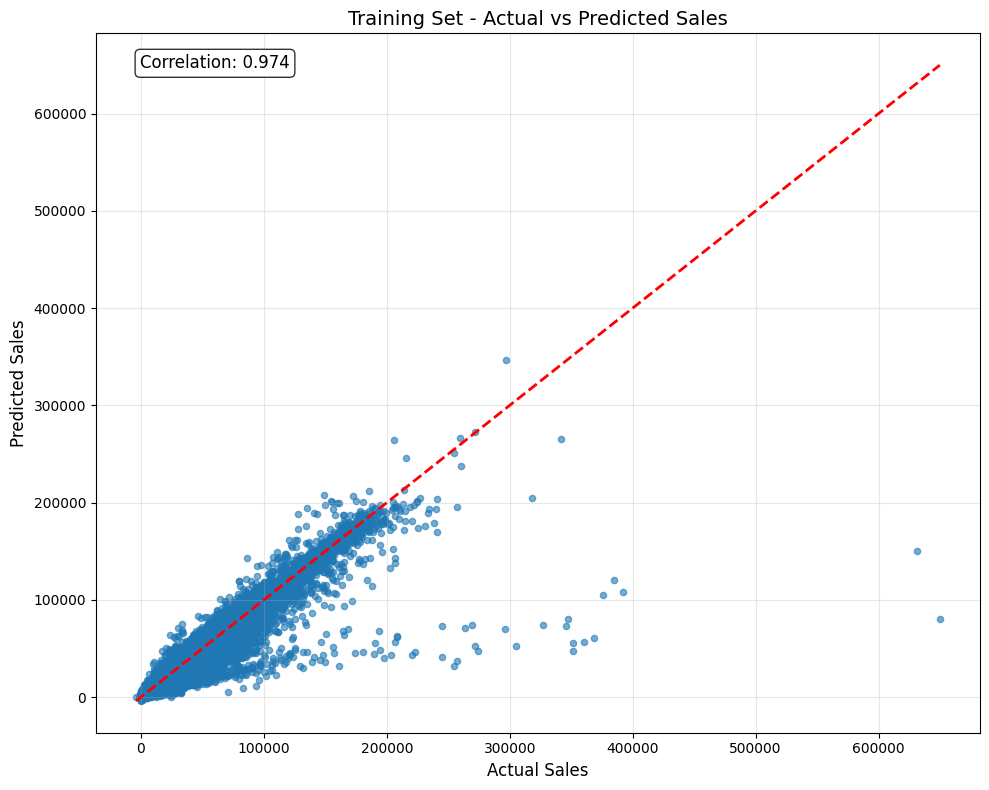

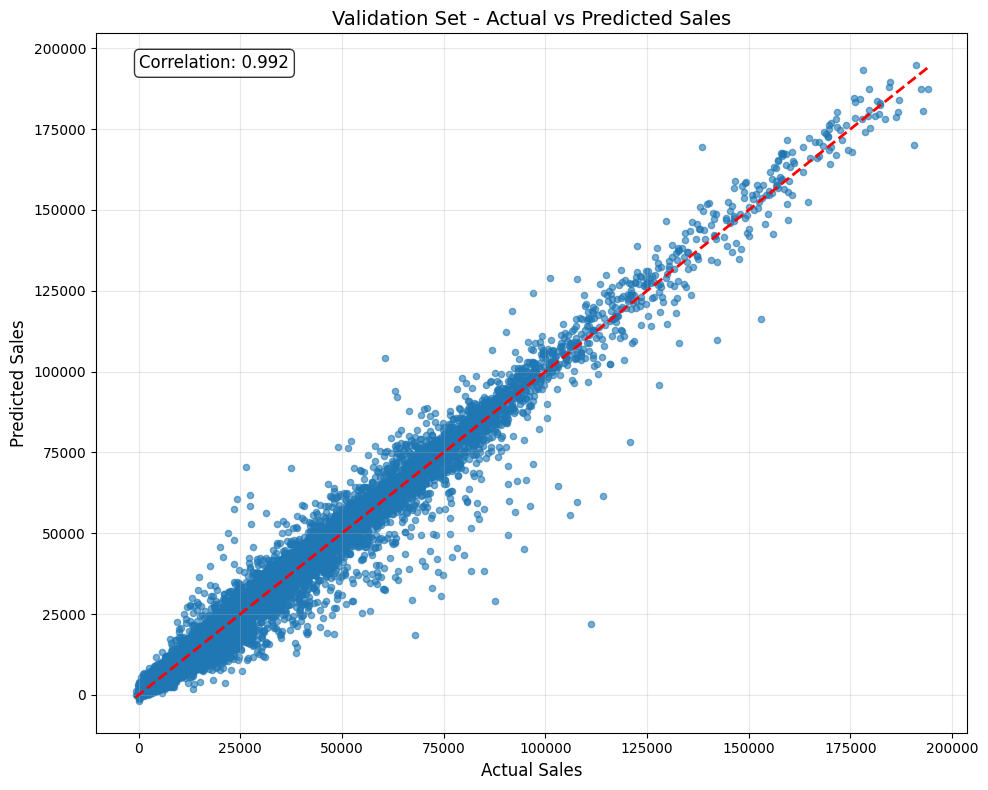


TRAINING COMPLETE
Final Validation WMAE: 1219.45
Model Bias: 129.10 (Over-predicting)
Prediction Consistency (Std): 2738.15
Store Performance Range: 1863.34
Number of features used: 18
🏃 View run DLinear_temporal_features at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/8/runs/dc0bd1f0e2d64b41b6d37b99df011731
🧪 View experiment at: https://dagshub.com/Cimbir/Store-Sales-Forecasting.mlflow/#/experiments/8


In [166]:
mlflow.set_experiment(config.experiment_name)

with mlflow.start_run(run_name="DLinear_temporal_features"):
    mlflow.log_param("lookback", config.lookback)
    mlflow.log_param("horizon", config.horizon)
    mlflow.log_param("batch_size", config.batch_size)
    mlflow.log_param("epochs", config.epochs)
    mlflow.log_param("lr", config.lr)
    mlflow.log_param("test_size", config.test_size)
    mlflow.log_param("lag_features", config.lag_features)
    mlflow.log_param("use_rolling_stats", config.use_rolling_stats)
    mlflow.log_param("rolling_windows", config.rolling_windows)


    pipeline = DLinearPipeline(config)
    pipeline.fit(df)

    train_metrics = evaluate_model(pipeline.model, pipeline.train_loader, "Training Set")
    val_metrics = evaluate_model(pipeline.model, pipeline.val_loader, "Validation Set")

    mlflow.log_metric("train_wmae", train_metrics[2])
    mlflow.log_metric("train_bias", train_metrics[3])
    mlflow.log_metric("train_error_std", train_metrics[4])
    mlflow.log_metric("val_wmae", val_metrics[2])
    mlflow.log_metric("val_bias", val_metrics[3])
    mlflow.log_metric("val_error_std", val_metrics[4])


    plot_actual_vs_predicted(train_metrics[0], train_metrics[1], "Training Set")
    plot_actual_vs_predicted(val_metrics[0], val_metrics[1], "Validation Set")

    joblib.dump(pipeline, "dlinear_pipeline.pkl")
    mlflow.log_artifact("dlinear_pipeline.pkl")

    print(f"\n{'='*60}")
    print("TRAINING COMPLETE")
    print(f"{'='*60}")
    print(f"Final Validation WMAE: {val_metrics[2]:.2f}")
    print(f"Model Bias: {val_metrics[3]:.2f} ({'Over' if val_metrics[3] > 0 else 'Under'}-predicting)")
    print(f"Prediction Consistency (Std): {val_metrics[4]:.2f}")
    print(f"Store Performance Range: {val_metrics[5]['mean'].max() - val_metrics[5]['mean'].min():.2f}")
    print(f"Number of features used: {pipeline.model.n_features}")